In [1]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score, roc_curve,ConfusionMatrixDisplay,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

C:\Users\merow\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Import 2017-05 Data

In [2]:
df=pd.read_csv('green_tripdata_{17}-{8}encoded.csv')

In [3]:
df.head()

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,pickup_datetime,pickup_hour,pickup_day_of_week,duration,duration_seconds,weekend
0,0,2017-08-01 00:21:35,2017-08-01 00:27:59,0,0,0,0,1.0,1.43,7.0,...,0.3,9.96,0,0,2017-08-01 00:21:35,0,1,2024-06-08 00:06:24,384,False
1,0,2017-08-01 00:37:27,2017-08-01 00:39:02,0,0,1,1,1.0,1.09,3.5,...,0.3,4.80,1,0,2017-08-01 00:37:27,0,1,2024-06-08 00:01:35,95,False
2,0,2017-08-01 00:04:03,2017-08-01 00:05:45,0,0,2,2,1.0,1.09,3.5,...,0.3,4.80,1,0,2017-08-01 00:04:03,0,1,2024-06-08 00:01:42,102,False
3,0,2017-08-01 00:05:23,2017-08-01 00:09:20,0,0,0,0,2.0,1.12,5.5,...,0.3,8.16,0,0,2017-08-01 00:05:23,0,1,2024-06-08 00:03:57,237,False
4,0,2017-08-01 00:29:09,2017-08-01 00:34:44,0,0,3,3,2.0,1.09,6.0,...,0.3,7.30,1,0,2017-08-01 00:29:09,0,1,2024-06-08 00:05:35,335,False


In [4]:
print(df.columns)

Index(['vendor', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'rate_type', 'pu_location', 'do_location',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'pickup_datetime', 'pickup_hour',
       'pickup_day_of_week', 'duration', 'duration_seconds', 'weekend'],
      dtype='object')


## Add a New Column for Price Range

In [5]:
# Determine the quantiles for categorizing price range
low_threshold = df['total_amount'].quantile(0.33)
medium_threshold = df['total_amount'].quantile(0.66)

# Define the price range based on quantiles
def categorize_price(total_amount):
    if total_amount <= low_threshold:
        return 'low'
    elif low_threshold < total_amount <= medium_threshold:
        return 'medium'
    else:
        return 'high'

# Apply the function to the DataFrame
df['price_range'] = df['total_amount'].apply(categorize_price)

# Inspect the DataFrame to check the new column
print(df[['total_amount', 'price_range']].head())
print(df['price_range'].value_counts())


   total_amount price_range
0          9.96      medium
1          4.80         low
2          4.80         low
3          8.16         low
4          7.30         low
price_range
low       294507
high      293801
medium    278465
Name: count, dtype: int64


## Pre-processing of the dataset

#### Split Data into Training and Testing Sets

In [6]:
# Convert datetime columns to datetime objects
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
# Extract datetime features
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['lpep_pickup_datetime'].dt.day
df['pickup_month'] = df['lpep_pickup_datetime'].dt.month
df['dropoff_hour'] = df['lpep_dropoff_datetime'].dt.hour
df['dropoff_day'] = df['lpep_dropoff_datetime'].dt.day
df['dropoff_month'] = df['lpep_dropoff_datetime'].dt.month
# Drop the original datetime columns
df=df.drop(columns=['total_amount','fare_amount','mta_tax','tip_amount','extra','tolls_amount','improvement_surcharge','lpep_pickup_datetime', 'lpep_dropoff_datetime','duration','pickup_datetime'])

In [7]:
df.head()

,vendor,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,payment_type,trip_type,pickup_hour,pickup_day_of_week,duration_seconds,weekend,price_range,pickup_day,pickup_month,dropoff_hour,dropoff_day,dropoff_month
0,0,0,0,0,0,1.0,1.43,0,0,0,1,384,False,medium,1,8,0,1,8
1,0,0,0,1,1,1.0,1.09,1,0,0,1,95,False,low,1,8,0,1,8
2,0,0,0,2,2,1.0,1.09,1,0,0,1,102,False,low,1,8,0,1,8
3,0,0,0,0,0,2.0,1.12,0,0,0,1,237,False,low,1,8,0,1,8
4,0,0,0,3,3,2.0,1.09,1,0,0,1,335,False,low,1,8,0,1,8


In [8]:
print(df.columns)

Index(['vendor', 'store_and_fwd_flag', 'rate_type', 'pu_location',
       'do_location', 'passenger_count', 'trip_distance', 'payment_type',
       'trip_type', 'pickup_hour', 'pickup_day_of_week', 'duration_seconds',
       'weekend', 'price_range', 'pickup_day', 'pickup_month', 'dropoff_hour',
       'dropoff_day', 'dropoff_month'],
      dtype='object')


In [11]:
# Separate features and target
x = df.drop(columns=['price_range'])
y = df['price_range']

# Define categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to the data
X = preprocessor.fit_transform(x)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(693418, 17) (173355, 17)
(693418,) (173355,)


## Implement Algorithms

### K Nearest Neighbors Classification

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the model
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

        high       0.90      0.87      0.89     58871
         low       0.78      0.86      0.82     58636
      medium       0.71      0.66      0.68     55848

    accuracy                           0.80    173355
   macro avg       0.80      0.80      0.80    173355
weighted avg       0.80      0.80      0.80    173355



#### Configure what is the best K value

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


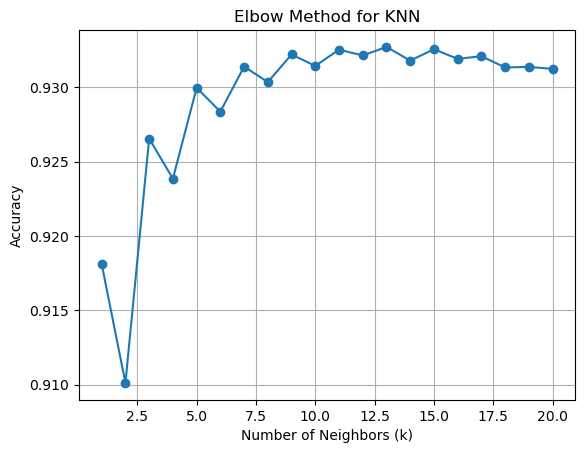

In [6]:
# Calculate performance for different k values
k_values = np.arange(1, 21)
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracies.append(knn.score(X_test, y_test))
    print(k)

# Plot the results
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Elbow Method for KNN")
plt.grid(True)
plt.show()

### Function to Plot Confusion Matrix

In [13]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

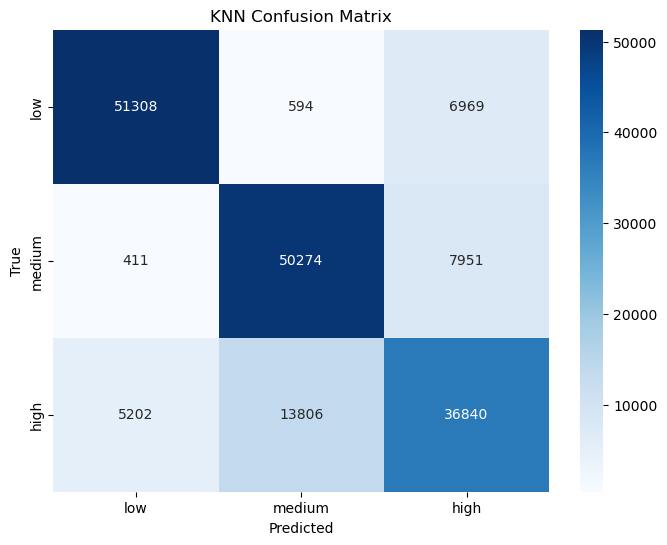

In [14]:
# KNN
plot_confusion_matrix(y_test, y_pred_knn, "KNN Confusion Matrix")

### KNN Voronoi diagram

In [15]:
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

In [16]:
# Train the KNN classifier in 2D space
nn_2d = KNeighborsClassifier(n_neighbors=5)
nn_2d.fit(X_train_2d, y_train)

KNeighborsClassifier()

In [17]:
# Create a mesh grid for plotting the decision boundaries
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [18]:
# Predict on the mesh grid
Z = nn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

In [19]:
label_map = {'low': 0, 'medium': 1, 'high': 2}
Z_numeric = np.vectorize(label_map.get)(Z)

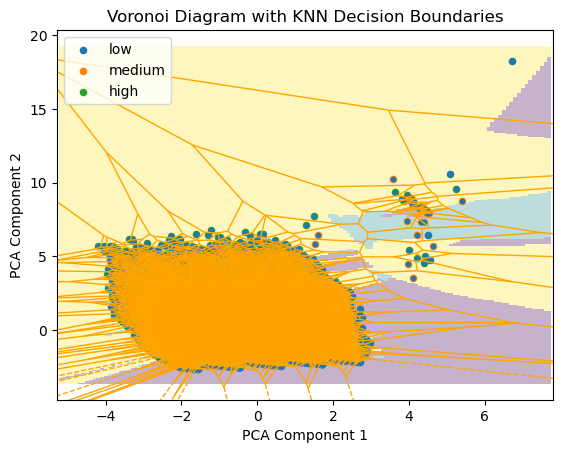

In [20]:
# Plot the decision boundaries using pcolormesh
plt.pcolormesh(xx, yy, Z_numeric, alpha=0.3)

# Plot points for each category separately
for category in ['low', 'medium', 'high']:
    mask = (y_train == category)
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], label=category, s=20)

# Compute the Voronoi diagram
vor = Voronoi(X_train_2d)
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='orange')

plt.title('Voronoi Diagram with KNN Decision Boundaries')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


#### Visualizing Feature Importance

In [ ]:
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(X_test.shape[1]), result.importances_mean[sorted_idx], align="center")
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


#### Learning Curve

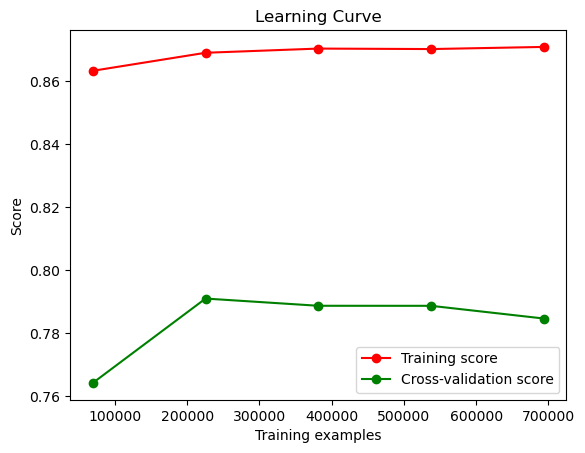

In [21]:
train_sizes, train_scores, test_scores = learning_curve(knn, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve')
plt.show()

#### Cross Validation

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)  # You can adjust the number of folds (cv) as needed
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())